# Machine Learning applied to TDF Data

In [1]:
# Import Libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Ignore futurewarnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Importing Machine Learning libraries/tools

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC

from sklearn.model_selection import cross_val_score

from sklearn.tree import DecisionTreeRegressor
%matplotlib inline
from sklearn.tree import plot_tree

In [3]:
Results_df = pd.DataFrame(columns=['Models','Train_Score','Test_Score'])
Results_df

,Models,Train_Score,Test_Score


In [4]:
# Import data from CSV file
TDF_GC = pd.read_csv('DATA/TDF_GC_with_rider_metrics.csv')

In [5]:
# Glance at untouched data
TDF_GC.head()

,Rank,Prev_rank,Rider_name,Team_name,Points,Time,Year,Weight(kg),Height(m),Age
0,1,1,POGAČAR Tadej,UAE-Team Emirates,500.0,82:56:36,2021,66.0,1.76,23
1,1,1,POGAČAR Tadej,UAE-Team Emirates,500.0,87:20:05,2020,66.0,1.76,22
2,2,2,VINGEGAARD Jonas,Team Jumbo-Visma,380.0,5:205:20,2021,60.0,1.75,25
3,3,3,CARAPAZ Richard,INEOS Grenadiers,340.0,7:037:03,2021,62.0,1.70,28
4,13,13,CARAPAZ Richard,INEOS Grenadiers,170.0,25:5325:53,2020,62.0,1.70,27


- Dropping Prev_Rank, as its not very usefull for determining overall winener before the race begins as its telling us the ranking before the last stage of TDF
- Dropping Time as its not a feature we will have available before a race, and running classification (not regression) for now

In [6]:
TDF_GC = TDF_GC.drop(['Rider_name','Prev_rank','Time'],axis=1)

In [7]:
# Shape of current data-set
TDF_GC.shape

(1741, 7)

In [8]:
# Checking for null values in the data frame
TDF_GC.isna().sum()

Rank          0
Team_name     0
Points        0
Year          0
Weight(kg)    0
Height(m)     0
Age           0
dtype: int64

No Null values.

- `Rank`: What position a rider came in
- `Rider_name`: Name of the cyclist/rider
- `Team_name`: Name of the team the rider rides for
- `Points`: Points based on Rank the rider finished in
- `Time`: Time it took to complete the whole Tour De France (Only winner is absolute, rest are relative)
- `Year`: The Year of the race
- `Weight(kg)`: Weight of the rider in Kilograms
- `Height(m)`: Height of rider in meters
- `Age`: Age of rider the year they competed in years

- `Rank`, `Points`, & `Time` all hold the same information
    - `Rank` every year there may be different number of riders who finish
    - `Points` has 35 unique values and can be used for classification
        - Everyone ranked 35 or lower ends up with 25 points
        - Unique values for everyone from 1 to 34
        - Not sure of the relationship between rank and points awarded
    - `Time` is different every year depending on how long the course is, may not train the model well as winning time for one year might be equivalent of 10th position another year?

# Using Points as classifier, no Rider_name

In [9]:
TDF_GC = TDF_GC.drop(['Rank'],axis=1)

In [10]:
# Checking data types and null values
TDF_GC.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1741 entries, 0 to 1740
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Team_name   1741 non-null   object 
 1   Points      1741 non-null   float64
 2   Year        1741 non-null   int64  
 3   Weight(kg)  1741 non-null   float64
 4   Height(m)   1741 non-null   float64
 5   Age         1741 non-null   int64  
dtypes: float64(3), int64(2), object(1)
memory usage: 81.7+ KB


### Changing data types to reduce memory use and run time

In [11]:
TDF_GC.Year = TDF_GC.Year.astype('int16')
TDF_GC['Weight(kg)'] = TDF_GC['Weight(kg)'].astype('float16')
TDF_GC['Height(m)'] = TDF_GC['Height(m)'].astype('float32')
TDF_GC.Age = TDF_GC.Age.astype('int8')
TDF_GC.Points = TDF_GC.Points.astype('int16')

In [12]:
# Checking if the change took place
TDF_GC.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1741 entries, 0 to 1740
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Team_name   1741 non-null   object 
 1   Points      1741 non-null   int16  
 2   Year        1741 non-null   int16  
 3   Weight(kg)  1741 non-null   float16
 4   Height(m)   1741 non-null   float32
 5   Age         1741 non-null   int8   
dtypes: float16(1), float32(1), int16(2), int8(1), object(1)
memory usage: 32.4+ KB


In [13]:
TDF_GC.head()

,Team_name,Points,Year,Weight(kg),Height(m),Age
0,UAE-Team Emirates,500,2021,66.0,1.76,23
1,UAE-Team Emirates,500,2020,66.0,1.76,22
2,Team Jumbo-Visma,380,2021,60.0,1.75,25
3,INEOS Grenadiers,340,2021,62.0,1.70,28
4,INEOS Grenadiers,170,2020,62.0,1.70,27


In [14]:
# One hot encoding rider names
# TDF_GC = TDF_GC.join(pd.get_dummies(TDF_GC.Rider_name))
# TDF_GC.shape

In [15]:
# One hot encoding team names
TDF_GC = TDF_GC.join(pd.get_dummies(TDF_GC.Team_name))
TDF_GC.shape

(1741, 109)

In [17]:
# Dropping the last 2 categorical columns
TDF_GC = TDF_GC.drop(['Team_name'],axis=1)
TDF_GC.shape

(1741, 108)

In [18]:
TDF_GC.head()

,Points,Year,Weight(kg),Height(m),Age,AG2R Citroën Team,AG2R La Mondiale,Alpecin-Fenix,Argos - Shimano,Astana - Premier Tech,...,Team TotalEnergies,Tinkoff,Tinkoff - Saxo,Trek - Segafredo,Trek Factory Racing,UAE Team Emirates,UAE-Team Emirates,Vacansoleil - DCM,Wanty - Gobert Cycling Team,Wanty - Groupe Gobert
0,500,2021,66.0,1.76,23,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,500,2020,66.0,1.76,22,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,380,2021,60.0,1.75,25,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,340,2021,62.0,1.70,28,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,170,2020,62.0,1.70,27,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [19]:
# Dropping the year column
# TDF_GC = TDF_GC.drop(['Year'],axis=1)
# TDF_GC.shape

## Train/Test Split

In [20]:
# Splitting Dataset into Data(Features) and Target
Data = TDF_GC.drop(['Points'],axis=1)
Target = TDF_GC.Points

In [21]:
# Taking a random 20% chunk for our test set, making sure to stratify our target
GC_rem_data, GC_test_data, GC_rem_target, GC_test_target = \
    train_test_split(Data, Target, test_size = 0.2, random_state=1, stratify=Target)

In [22]:
# Splitting the remainder in two chunks for training and validation (70% of remainder for training)
GC_train_data, GC_val_data, GC_train_target, GC_val_target = \
    train_test_split(GC_rem_data, GC_rem_target, test_size = 0.3, random_state=1, stratify=GC_rem_target)

## Logistic Regression - Hyperparamter Optimization

In [23]:
# Optimizing our Hyperparameters to get the best results
validation_scores = []
train_scores = []

C_range = np.array([.00000001,.0000001,.000001,.00001,.0001,.001,0.1,\
                1,10,100,1000,10000,100000,1000000,10000000,100000000,1000000000])

for c in C_range:
    my_logreg = LogisticRegression(C = c,random_state=1)
    my_logreg.fit(GC_train_data,GC_train_target)
    
    # train on traning set
    train_scores.append(my_logreg.score(GC_train_data,GC_train_target))
    # score on validation set
    validation_scores.append(my_logreg.score(GC_val_data,GC_val_target))

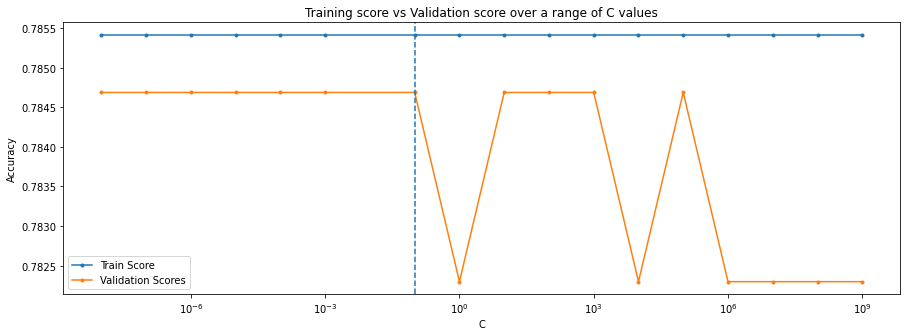

In [24]:
# Plotting the training and validation scores
plt.figure(figsize=(15,5))
plt.plot(C_range, train_scores,label="Train Score",marker='.')
plt.plot(C_range, validation_scores,label="Validation Scores",marker='.')
plt.xscale('log')
plt.title('Training score vs Validation score over a range of C values')
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.axvline(0.1, linestyle = '--')
plt.legend()
plt.show()

In [25]:
# Instatiate with optimal hyperparameters
log_reg = LogisticRegression(C=0.1,random_state=1)

# Fitting the model to the complete train/validate set
log_reg.fit(GC_rem_data, GC_rem_target)
log_reg.score(GC_test_data,GC_test_target)

0.7851002865329513

In [26]:
# Prediciting our test set
model_predictions = log_reg.predict(GC_test_data)

In [27]:
# Looking at the predictions
model_predictions

array([25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25,
       25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25,
       25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25,
       25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25,
       25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25,
       25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25,
       25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25,
       25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25,
       25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25,
       25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25,
       25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25,
       25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25,
       25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25,
       25, 25, 25, 25, 25

Again it predicts every rider to come below 34th rank, and artifically gets a high score

In [28]:
# Adding reults to a scoring dataframe
Results_df.loc[5] = ('Logistic Regression with H.O. & Points', log_reg.score(GC_rem_data, GC_rem_target) , log_reg.score(GC_test_data, GC_test_target))
Results_df

,Models,Train_Score,Test_Score
5,Logistic Regression with H.O. & Points,0.785201,0.7851


## K Nearest Neighbours - Hyperparameter Optimization

In [29]:
# The different K values to try out and save to 'neighbors'
neighbors = range(1, 50, 1)

# Empty lists to append the accuracies to 
train = []
validate = []

# Loop through neighbors
for K in neighbors:
    
    # Instantiate the model 
    KNN = KNeighborsClassifier(n_neighbors=K)
    
    # Fit the model 
    KNN.fit(GC_train_data, GC_train_target)
    
    # Score the model 
    train.append(KNN.score(GC_train_data, GC_train_target))
    validate.append(KNN.score(GC_val_data, GC_val_target))

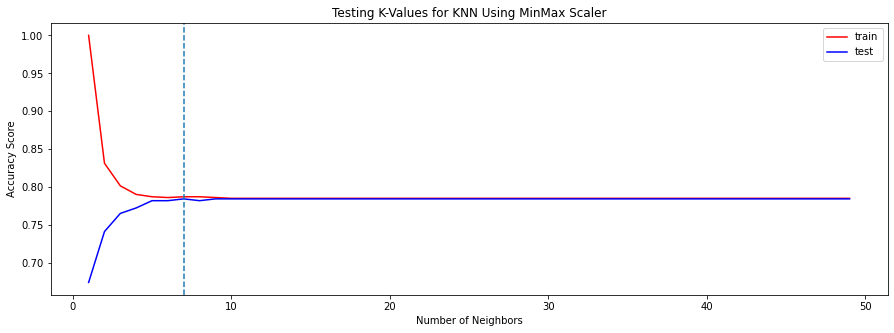

In [61]:
# Plot the accuracy scores
plt.figure(figsize=(15,5))
plt.plot(neighbors, train, c='red', label='train')
plt.plot(neighbors, validate, c='blue', label='test')
plt.xlabel("Number of Neighbors")
plt.ylabel("Accuracy Score")
plt.title('Testing K-Values for KNN Using MinMax Scaler')
plt.axvline(7, linestyle = '--')
plt.legend()
plt.show()

In [31]:
# Fitting our KNN model with optimized hyperparameters to the full train/validation set
KNN = KNeighborsClassifier(n_neighbors=7)
KNN.fit(GC_rem_data, GC_rem_target)

KNeighborsClassifier()

In [32]:
# Scoring our model on the test set
KNN.score(GC_test_data, GC_test_target)

0.7765042979942693

In [33]:
# Adding reults to a scoring dataframe
Results_df.loc[6] = ('KNN with H.O. & Points', KNN.score(GC_rem_data, GC_rem_target) , KNN.score(GC_test_data, GC_test_target))
Results_df

,Models,Train_Score,Test_Score
5,Logistic Regression with H.O. & Points,0.785201,0.785100
6,KNN with H.O. & Points,0.787356,0.776504


## Decision Tree - Hyperparameter Optimization

In [34]:
# A list of the maximum depths to try out
depths = range(1, int(np.sqrt(GC_train_data.shape[0])))

In [35]:
# Empty lists to append to
train_DT = []
validate_DT = []

# Loop through the depths
for max_depth in depths:
    
    # Instantiate the model 
    DT = DecisionTreeClassifier(max_depth=max_depth, random_state=11)
    
    # Fit the model 
    DT.fit(GC_train_data, GC_train_target)
    
    # Score the model 
    train_DT.append(DT.score(GC_train_data, GC_train_target))
    validate_DT.append(DT.score(GC_val_data, GC_val_target))

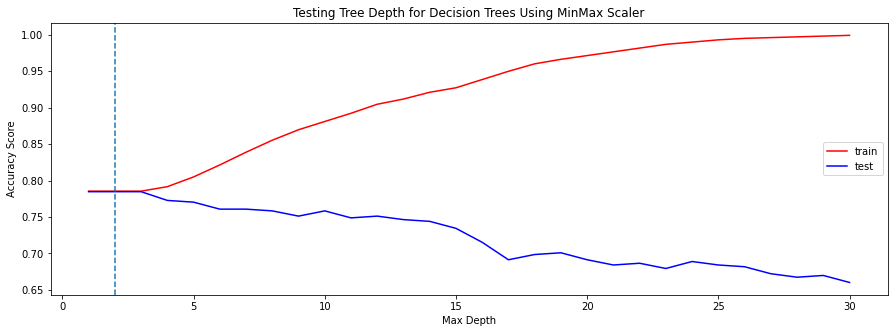

In [36]:
# Plotting the accuracy scores
plt.figure(figsize=(15,5))
plt.plot(depths, train_DT, c='red', label='train')
plt.plot(depths, validate_DT, c='blue', label='test')
plt.xlabel("Max Depth")
plt.ylabel("Accuracy Score")
plt.title('Testing Tree Depth for Decision Trees Using MinMax Scaler')
plt.axvline(2, linestyle = '--')
plt.legend()
plt.show()

In [37]:
# Instantiating the model with optimized hyper parameters
DT = DecisionTreeClassifier(max_depth=2, random_state=42)

# Fit the model 
DT.fit(GC_rem_data, GC_rem_target)

# Store accuracy scores on full training set and test set
DT_train = DT.score(GC_rem_data, GC_rem_target)
DT_test = DT.score(GC_test_data, GC_test_target)

# Score the model 
print(f"Train Accuracy: {DT_train}")
print(f"Test Accuracy: {DT_test}")

Train Accuracy: 0.7852011494252874
Test Accuracy: 0.7851002865329513


In [38]:
# Adding reults to a scoring dataframe
Results_df.loc[7] = ('Decission Tree with H.O. & Points', DT.score(GC_rem_data, GC_rem_target) , DT.score(GC_test_data, GC_test_target))
Results_df

,Models,Train_Score,Test_Score
5,Logistic Regression with H.O. & Points,0.785201,0.785100
6,KNN with H.O. & Points,0.787356,0.776504
7,Decission Tree with H.O. & Points,0.785201,0.785100


## Support Vector Machines - Hyperparameter Optimization

In [39]:
# Trying to optimize hyper parameters for SVM, even though its tricky

validation_scores_svm = []
train_scores_svm = []

C_range = np.array([.00000001,.0000001,.000001,.00001,.0001,.001,0.1,\
                1,10,100,1000,10000,100000,1000000,10000000,100000000,1000000000])

for c in C_range:
    SVM = LinearSVC(C = c, random_state=1)
    SVM.fit(GC_train_data, GC_train_target)
    
    # train on traning set
    train_scores_svm.append(SVM.score(GC_train_data,GC_train_target))
    # score on validation set
    validation_scores_svm.append(SVM.score(GC_val_data,GC_val_target))

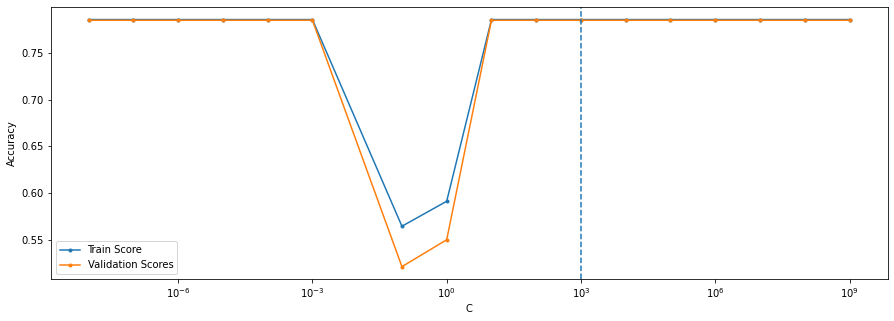

In [40]:
# Plotting the SVM scores over a range of c values
plt.figure(figsize=(15,5))
plt.plot(C_range, train_scores_svm,label="Train Score",marker='.')
plt.plot(C_range, validation_scores_svm,label="Validation Scores",marker='.')
plt.xscale('log')
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.axvline(1000, linestyle = '--')
plt.legend()
plt.show();

In [41]:
# Fitting our SVM model to the complete training/validation set
SVM = LinearSVC(C=1000,random_state=1)
SVM.fit(GC_rem_data,GC_rem_target)

LinearSVC(C=1000, random_state=1)

In [42]:
# Printing the scores
print(f"The TRAIN classification accuracy is: {SVM.score(GC_rem_data,GC_rem_target)}")
print(f"The TEST classification accuracy is: {SVM.score(GC_test_data, GC_test_target)}")

The TRAIN classification accuracy is: 0.7852011494252874
The TEST classification accuracy is: 0.7851002865329513


In [43]:
# Adding reults to a scoring dataframe
Results_df.loc[8] = ('SVM with H.O. & Points', SVM.score(GC_rem_data, GC_rem_target) , SVM.score(GC_test_data, GC_test_target))
Results_df

,Models,Train_Score,Test_Score
5,Logistic Regression with H.O. & Points,0.785201,0.785100
6,KNN with H.O. & Points,0.787356,0.776504
7,Decission Tree with H.O. & Points,0.785201,0.785100
8,SVM with H.O. & Points,0.785201,0.785100


# Principal Component Analysis

In [44]:
# Insantiate
my_PCA = PCA()
# Fit the PCA object to the data
my_PCA.fit(GC_train_data)

PCA()

In [45]:
# Transform the original data.
GC_train_data_PCA = my_PCA.transform(GC_train_data)
GC_val_data_PCA = my_PCA.transform(GC_val_data)
GC_rem_data_PCA = my_PCA.transform(GC_rem_data)
GC_test_data_PCA = my_PCA.transform(GC_test_data)

## PCA - Logistic Regression with Hyperparameter Optimization

In [46]:
# Hyperparamter Optimization with PCA Data
validation_scores = []
train_scores = []

C_range = np.array([.00000001,.0000001,.000001,.00001,.0001,.001,0.1,\
                1,10,100,1000,10000,100000,1000000,10000000,100000000,1000000000])

for c in C_range:
    my_logreg = LogisticRegression(C = c,random_state=1)
    my_logreg.fit(GC_train_data_PCA, GC_train_target)
    
    # train on traning set
    train_scores.append(my_logreg.score(GC_train_data_PCA, GC_train_target))
    # score on validation set
    validation_scores.append(my_logreg.score(GC_val_data_PCA, GC_val_target))

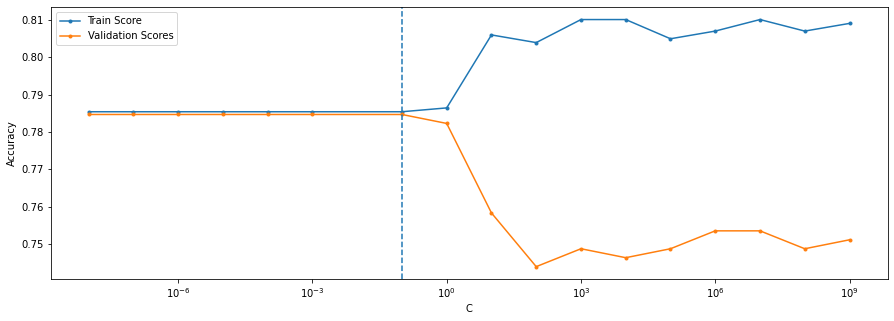

In [47]:
# Plotting the scores
plt.figure(figsize=(15,5))
plt.plot(C_range, train_scores,label="Train Score",marker='.')
plt.plot(C_range, validation_scores,label="Validation Scores",marker='.')
plt.xscale('log')
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.axvline(0.1, linestyle = '--')
plt.legend()
plt.show();

In [48]:
# Instantiate with optimal hyperparameters
my_logreg = LogisticRegression(C=0.1,random_state=1)

# Fitting the model to complete train/validate data
my_logreg.fit(GC_rem_data_PCA, GC_rem_target)
my_logreg.score(GC_test_data_PCA, GC_test_target)

0.7851002865329513

In [49]:
# Adding reults to a scoring dataframe
Results_df.loc[9] = ('Logistic Regression with PCA & Points', my_logreg.score(GC_rem_data_PCA, GC_rem_target) , my_logreg.score(GC_test_data_PCA, GC_test_target))
Results_df

,Models,Train_Score,Test_Score
5,Logistic Regression with H.O. & Points,0.785201,0.785100
6,KNN with H.O. & Points,0.787356,0.776504
7,Decission Tree with H.O. & Points,0.785201,0.785100
8,SVM with H.O. & Points,0.785201,0.785100
9,Logistic Regression with PCA & Points,0.785201,0.785100


## PCA - KNN - Hyperparameter Optimization

In [50]:
# The different K values to try out and save to 'neighbors'
neighbors = range(1, 50, 1)

# Empty lists to append the accuracies to 
train = []
validate = []

# Loop through neighbors
for K in neighbors:
    
    # Instantiate the model 
    KNN = KNeighborsClassifier(n_neighbors=K)
    
    # Fit the model 
    KNN.fit(GC_train_data_PCA, GC_train_target)
    
    # Score the model 
    train.append(KNN.score(GC_train_data_PCA, GC_train_target))
    validate.append(KNN.score(GC_val_data_PCA, GC_val_target))

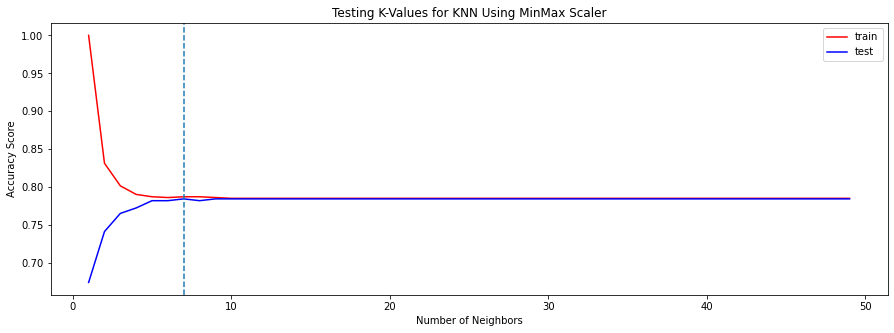

In [62]:
# Plot the accuracies 
plt.figure(figsize=(15,5))
plt.plot(neighbors, train, c='red', label='train')
plt.plot(neighbors, validate, c='blue', label='test')
plt.xlabel("Number of Neighbors")
plt.ylabel("Accuracy Score")
plt.title('Testing K-Values for KNN Using MinMax Scaler')
plt.axvline(7, linestyle = '--')
plt.legend()
plt.show()

In [52]:
KNN = KNeighborsClassifier(n_neighbors=7)
KNN.fit(GC_rem_data_PCA, GC_rem_target)

KNeighborsClassifier()

In [53]:
KNN.score(GC_test_data_PCA, GC_test_target)

0.7765042979942693

In [54]:
# Adding reults to a scoring dataframe
Results_df.loc[10] = ('KNN with PCA & Points', KNN.score(GC_rem_data_PCA, GC_rem_target) , KNN.score(GC_test_data_PCA, GC_test_target))
Results_df

,Models,Train_Score,Test_Score
5,Logistic Regression with H.O. & Points,0.785201,0.785100
6,KNN with H.O. & Points,0.787356,0.776504
7,Decission Tree with H.O. & Points,0.785201,0.785100
8,SVM with H.O. & Points,0.785201,0.785100
9,Logistic Regression with PCA & Points,0.785201,0.785100
10,KNN with PCA & Points,0.787356,0.776504


## PCA - Decision Tree - Hyperparameter Optimization

In [55]:
# A list of the maximum depths to try out and save to 'depths'
depths = range(1, int(np.sqrt(GC_train_data_PCA.shape[0])))

In [56]:
# Empty lists to append to
train_DT = []
validate_DT = []

# Loop through the depths
for max_depth in depths:
    
    # Instantiate the model 
    DT = DecisionTreeClassifier(max_depth=max_depth, random_state=11)
    
    # Fit the model 
    DT.fit(GC_train_data_PCA, GC_train_target)
    
    # Score the model 
    train_DT.append(DT.score(GC_train_data_PCA, GC_train_target))
    validate_DT.append(DT.score(GC_val_data_PCA, GC_val_target))

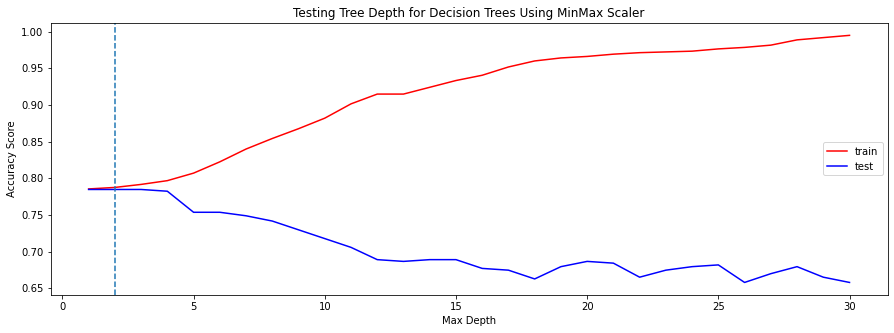

In [64]:
# Plotting the accuracies
plt.figure(figsize=(15,5))
plt.plot(depths, train_DT, c='red', label='train')
plt.plot(depths, validate_DT, c='blue', label='test')
plt.xlabel("Max Depth")
plt.ylabel("Accuracy Score")
plt.title('Testing Tree Depth for Decision Trees Using MinMax Scaler')
plt.axvline(2, linestyle = '--')
plt.legend()
plt.show()

In [58]:
# Instantiate Decision Tree model with optimal hyperparameters
DT = DecisionTreeClassifier(max_depth=2, random_state=11)

# Fit the model 
DT.fit(GC_rem_data_PCA, GC_rem_target)

# Store accuracy scores
DT_train = DT.score(GC_rem_data_PCA, GC_rem_target)
DT_test = DT.score(GC_test_data_PCA, GC_test_target)

# Score the model 
print(f"Train Accuracy: {DT_train}")
print(f"Test Accuracy: {DT_test}")

Train Accuracy: 0.7852011494252874
Test Accuracy: 0.7851002865329513


In [59]:
# Adding reults to a scoring dataframe
Results_df.loc[11] = ('DT with PCA & Points', DT.score(GC_rem_data_PCA, GC_rem_target) , DT.score(GC_test_data_PCA, GC_test_target))
Results_df

,Models,Train_Score,Test_Score
5,Logistic Regression with H.O. & Points,0.785201,0.785100
6,KNN with H.O. & Points,0.787356,0.776504
7,Decission Tree with H.O. & Points,0.785201,0.785100
8,SVM with H.O. & Points,0.785201,0.785100
9,Logistic Regression with PCA & Points,0.785201,0.785100
10,KNN with PCA & Points,0.787356,0.776504
11,DT with PCA & Points,0.785201,0.785100


# Results from all Models

In [60]:
Results_df

,Models,Train_Score,Test_Score
5,Logistic Regression with H.O. & Points,0.785201,0.785100
6,KNN with H.O. & Points,0.787356,0.776504
7,Decission Tree with H.O. & Points,0.785201,0.785100
8,SVM with H.O. & Points,0.785201,0.785100
9,Logistic Regression with PCA & Points,0.785201,0.785100
10,KNN with PCA & Points,0.787356,0.776504
11,DT with PCA & Points,0.785201,0.785100


Removing Rider_names did not seem to improve our model's score.